<a href="https://colab.research.google.com/github/fazmila/LLM/blob/main/LLM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers datasets tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from datasets import load_dataset

# Load the Emotion dataset
dataset = load_dataset('emotion')

<ipython-input-8-28bc6a5d3839>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=emotion_names, order=sorted(set(emotion_names)), palette="viridis")


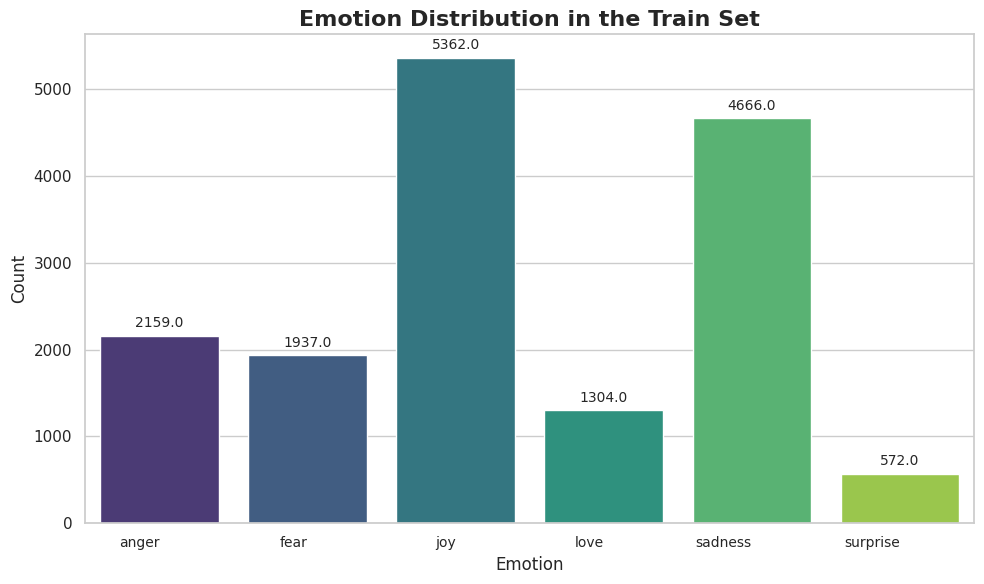

<ipython-input-8-28bc6a5d3839>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=emotion_names, order=sorted(set(emotion_names)), palette="viridis")


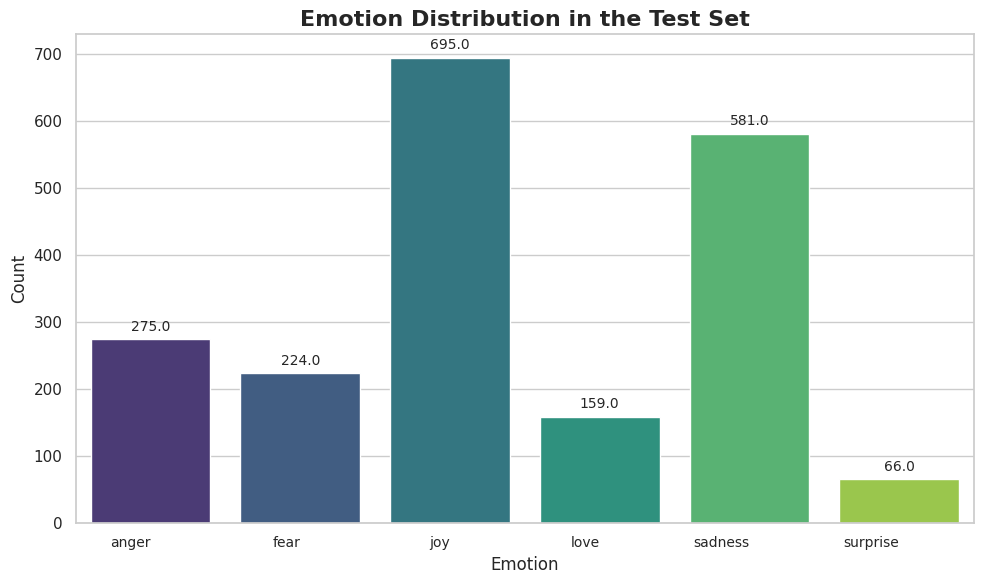

In [ ]:
# Visualize the distribution of emotions in the dataset
def visualize_emotions(dataset, split='train'):
    # Extract the data
    data = dataset[split]
    labels = data['label']

    # Mapping labels to their respective emotion names
    label_names = dataset[split].features['label'].int2str

    # Convert the labels to emotion names
    emotion_names = [label_names(label) for label in labels]

    # Set the visual style
    sns.set(style="whitegrid")

    # Plot the distribution with swapped axes and enhanced visuals
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=emotion_names, order=sorted(set(emotion_names)), palette="viridis")

    # Add title and labels
    plt.title(f'Emotion Distribution in the {split.capitalize()} Set', fontsize=16, fontweight='bold')
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Emotion', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0, ha='right', fontsize=10)

    # Add data labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

    # Improve layout
    plt.tight_layout()
    plt.show()

# Visualize the emotions in the train set
visualize_emotions(dataset, split='train')

# Optionally, visualize emotions in the test set
visualize_emotions(dataset, split='test')

In [ ]:
#Preprocessing
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Apply the tokenizer to the dataset
encoded_dataset = dataset.map(tokenize_function, batched=True)

# Set format for TensorFlow
encoded_dataset.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'label'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import tensorflow as tf

# Convert to TensorFlow dataset
def to_tf_dataset(dataset, batch_size=16):
    features = {x: tf.convert_to_tensor(dataset[x]) for x in ['input_ids', 'attention_mask']}
    labels = tf.convert_to_tensor(dataset['label'])
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

# Use a subset of the dataset for quicker experiments
train_dataset = to_tf_dataset(encoded_dataset['train'].select(range(2000)))
test_dataset = to_tf_dataset(encoded_dataset['test'].select(range(500)))


In [ ]:
from transformers import TFBertForSequenceClassification

# Load BERT model with a classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)  # Number of emotion categories

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
model.fit(train_dataset, validation_data=test_dataset, epochs=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
125/125 [==============================] - 3400s 27s/step - loss: 1.3076 - accuracy: 0.5000 - val_loss: 0.7947 - val_accuracy: 0.7480
Epoch 2/3
125/125 [==============================] - 3277s 26s/step - loss: 0.4962 - accuracy: 0.8415 - val_loss: 0.4721 - val_accuracy: 0.8440
Epoch 3/3
125/125 [==============================] - 3293s 26s/step - loss: 0.2397 - accuracy: 0.9265 - val_loss: 0.4038 - val_accuracy: 0.8860


In [ ]:
# Evaluate the model
eval_results = model.evaluate(test_dataset)
print(f"Evaluation results: {eval_results}")

# Save the model
model.save_pretrained('./fine-tuned-bert-emotion')
tokenizer.save_pretrained('./fine-tuned-bert-emotion')

32/32 [==============================] - 233s 7s/step - loss: 0.4038 - accuracy: 0.8860
Evaluation results: [0.40381288528442383, 0.8859999775886536]


('./fine-tuned-bert-emotion/tokenizer_config.json',
 './fine-tuned-bert-emotion/special_tokens_map.json',
 './fine-tuned-bert-emotion/vocab.txt',
 './fine-tuned-bert-emotion/added_tokens.json')

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Define the mapping from labels to emotions
emotion_labels = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}

# Load the fine-tuned model and tokenizer
model = TFBertForSequenceClassification.from_pretrained('./fine-tuned-bert-emotion')
tokenizer = BertTokenizer.from_pretrained('./fine-tuned-bert-emotion')

# Define a function for making predictions
def predict(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
    outputs = model(**inputs)
    predictions = tf.argmax(outputs.logits, axis=-1)
    return predictions.numpy()  # Ensure it returns a numpy array

# Example texts
texts = ["I am so happy today!", "I am feeling very sad."]
predictions = predict(texts)

# Check the structure of predictions
print("Predictions:", predictions)

# Map predictions to emotion names
predicted_emotions = [emotion_labels[int(pred)] for pred in predictions]

print(f"Predicted emotions: {predicted_emotions}")

Some layers from the model checkpoint at ./fine-tuned-bert-emotion were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./fine-tuned-bert-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Predictions: [1 0]
Predicted emotions: ['fear', 'anger']


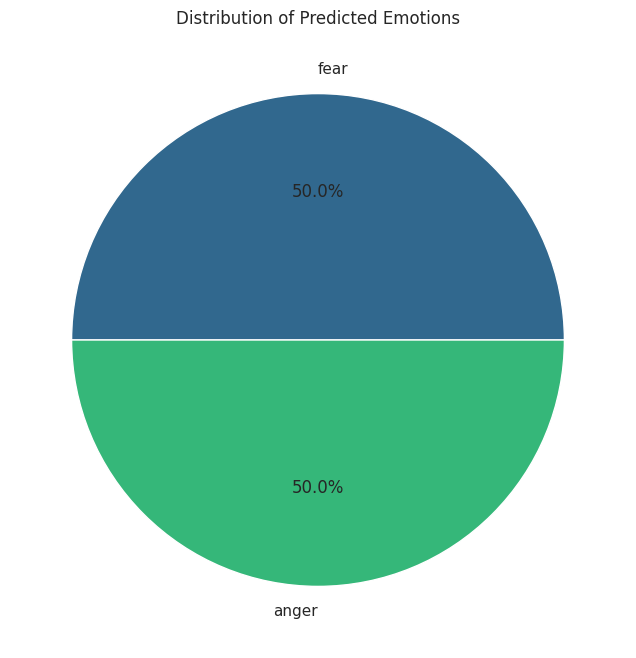

In [ ]:
import matplotlib.pyplot as plt
# Convert predictions to a pandas DataFrame
predicted_labels = [emotion_labels[int(pred)] for pred in predictions]
df_predictions = pd.DataFrame(predicted_labels, columns=['Predicted Emotion'])

# Create a pie chart for the predicted emotions
plt.figure(figsize=(10, 8))

# Count the occurrences of each predicted emotion
emotion_counts = df_predictions['Predicted Emotion'].value_counts()

# Plot the pie chart
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(emotion_counts)))
plt.title('Distribution of Predicted Emotions')
plt.show()